In [1]:
from bayes_opt import BayesianOptimization
import numpy as np
import networkx as nx
import sys
import random
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mping
import math

import graph
import ptline
import scenario_builder
import time
import pickle
import copy

import multiprocessing

import pandas as pd

In [2]:
# # Parameters
# debug = True # prints some messages useful to debug
# fast_execution = False
# assign_iterations = 4
# trip_generation_rate = 0.08
# pt_mode_share = 0.124
# walk_speed = 3.5 #Km/h
# v_bus = 30 # km/h
# tau_s = 15/3600 # (in hours) time spent per pickup or dropoff
# tau_T = 180/3600  # (in hours) dwell time. Time that a bus spends doing nothing at the
#                     # end of each cycle
# minimum_headway = 2 # in minutes

# graph_filename = 'montreal_graph.pkl'

In [3]:
import os
os.sched_setaffinity(0, {4})  # 让当前进程只运行在 CPU 核心 2

## 1. Load data ( Metro lines of Montreal )

In [4]:
#I = mping.imread('.\OpenStreetMap_Montreal.png')
#plt.imshow(I)
#plt.show()

In [5]:
walk_speed = 4.5
g = scenario_builder.build_initial_graph(walk_speed)

In [6]:
all_stations = g.all_stations
all_edges = g.all_edges
centr_id_matr = g.centr_id_matr
acc_matr_init = g.acc_matr

In [7]:
g_lines = nx.DiGraph(list_waiting_time=[], walking_speed=walk_speed)
g_lines.add_nodes_from([i for i in range( len(all_stations) )])
g_lines.add_edges_from(all_edges)

In [8]:
def revert_coordinates(stations, upmost):
    stations_reverted=[]
    for s in stations:
        stations_reverted.append( [s[0],upmost-s[1] ])
    return stations_reverted

In [9]:
from matplotlib.ticker import ScalarFormatter

def plot_heatmap(centr_id_matr, acc_matr, g, all_stations,\
          title, label):

    fig, ax= plt.subplots(figsize=(15, 15))
    im = ax.imshow(acc_matr,cmap = 'OrRd')
    fig.colorbar(im, ax=ax, shrink=0.5, label=label, format=ScalarFormatter())
    ax.set_title(title, fontsize=16)
  
    for i in range(centr_id_matr.shape[0]):
        for j in range(centr_id_matr.shape[1]):
            text = ax.text(j, i, f'{centr_id_matr[i,j]:.0f}',
                           ha="center", va="center", color="w")
    leftmost, rightmost, bottommost, upmost = g.find_limits()
  
    stations_rev = revert_coordinates(all_stations, upmost)
    nx.draw(g_lines, stations_rev, with_labels=False,node_color=g.node_color, node_size = g.node_size)

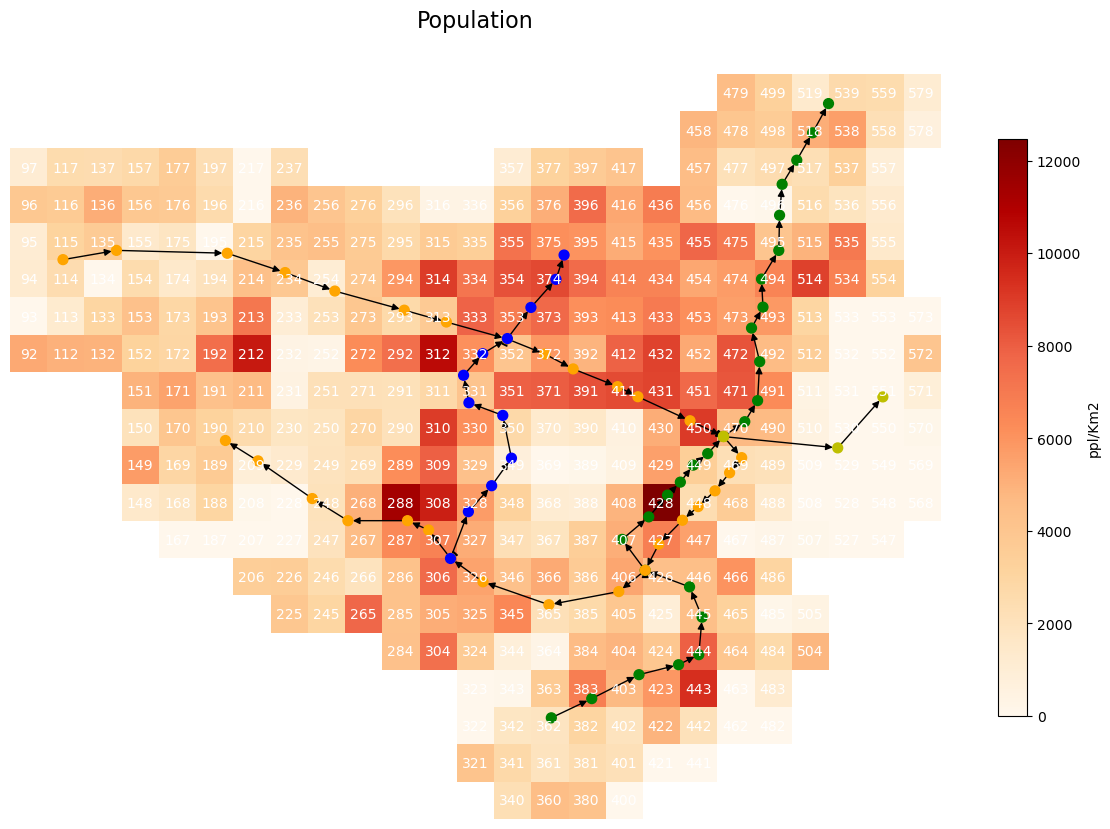

In [10]:
plot_heatmap(centr_id_matr, g.pop_matr, g, all_stations, "Population",\
               "ppl/Km2")

In [11]:
g_lines = nx.DiGraph(list_waiting_time=[], walking_speed=walk_speed)
g_lines.add_nodes_from([i for i in range( len(all_stations) )])
g_lines.add_edges_from(all_edges)

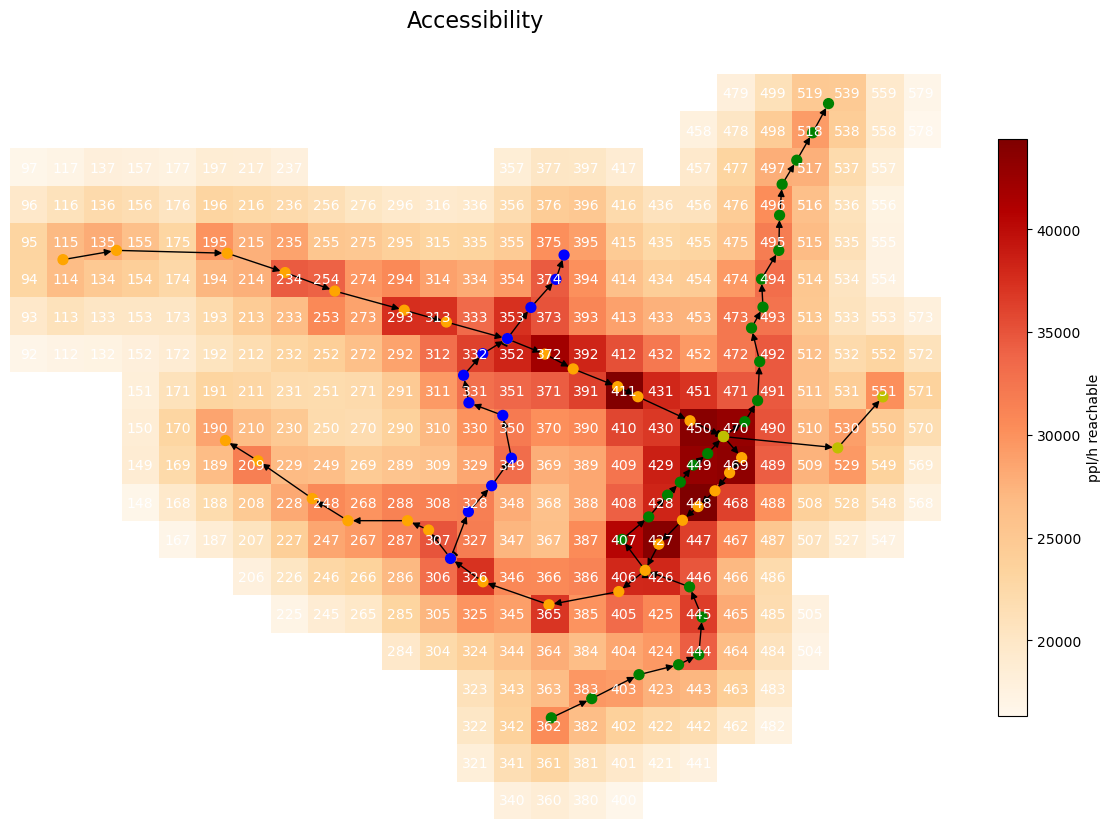

In [12]:
plot_heatmap(centr_id_matr, acc_matr_init, g, all_stations, "Accessibility",\
               "ppl/h reachable")

In [13]:
centroid_population = g.centroid_population
total_population = g.total_population
print(f"total_population={total_population} people")

total_population=1180140 people


In [14]:
np.array(g.compute_accessibility()[1]) 

array([16714.00872895, 19611.17188358, 22941.90063401, 23096.9673812 ,
       19677.87523915, 16567.43799672, 17145.30851846, 20854.77150277,
       26477.04537071, 26956.06466025, 20849.0758381 , 17068.19750747,
       17262.01674342, 20151.71671616, 24776.75762154, 28009.98707002,
       22208.15820229, 18027.06910611, 16557.00816435, 18751.33817995,
       18601.83775774, 18144.47480394, 18001.88081851, 20124.54394823,
       23943.94884864, 26011.77028735, 21687.515001  , 17834.97701474,
       16659.62490777, 19573.79422851, 22244.90800592, 22963.87451161,
       20839.54793842, 18793.46123696, 20137.45320281, 22481.16565484,
       22998.95267584, 20454.77960538, 17442.92617908, 18519.03842849,
       21973.52187454, 26523.63213446, 28519.44923868, 23205.44558861,
       20556.96971213, 22037.68328139, 27160.59299723, 29880.05556175,
       23107.53710103, 18635.74321564, 17787.84008822, 20571.2241471 ,
       24714.74141188, 31489.12928111, 26417.12648062, 22871.71323127,
      

## 2. DRT allocation function definitions

In [15]:
g.centroid_node

[92,
 93,
 94,
 95,
 96,
 97,
 112,
 113,
 114,
 115,
 116,
 117,
 132,
 133,
 134,
 135,
 136,
 137,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368

In [16]:
# All alternative areas
list_area = []
for i in range(80,580):
    if i in g.centroid_node and i+1 in g.centroid_node and i+20 in g.centroid_node and i+21 in g.centroid_node and i+40 in g.centroid_node and i+41 in g.centroid_node:

        list_area_population = [centroid_population[i],
                                centroid_population[i+1],
                                centroid_population[i+20],
                                centroid_population[i+21],
                                centroid_population[i+40],
                                centroid_population[i+41] ]

        if len( [ i for i in list_area_population if i == 0 ] ) <= 0:
            # We only consider areas that contain at most 2 0-population tiles
            list_area.append([i,i+1,i+20,i+21,i+40,i+41])

len(list_area)

# 0 zero population: 206
# 1 zero population: 27
# 2 zero population: 15
# 3 zero population: 3
# 4 zero population: 6
# 5 zero population: 4
# 6 zero population: 2
# 248 = 206 + 27 + 15

206

In [17]:
def find_s1(area,g):
# Find point "s_1" (see the paper) that is the first point visited by the
# DRT bus when it enters the area
    s1 = (g.centroid_to_pos[area[4]] + g.centroid_to_pos[area[5]])/2 + np.array([0.5,0])
    return s1

In [18]:
def findClosestStation(area,g):
    DRT_s_1 = find_s1(area,g)
    distance_station_area_list = []
    for i in g.metro_node:
        metro_pos_i = np.array(g.metro_pos[i])
        distance_station_area_list.append( np.linalg.norm( metro_pos_i - DRT_s_1 ) )

    closest_station = np.argmin( distance_station_area_list )
    return closest_station

In [19]:
def findWorstArea(g):
# Find area with worst Score and its nearest metro station

    alpha = 0.50

    list_acc =  g.compute_accessibility()[1]

    # Get the ranks of centroids related to accessibility and population
    # index_acc_dict: dict{ centroid index -> rank of acc }
    # index_popu_dict: dict{ centroid index -> rank of population }
    index_acc = np.argsort(list_acc)
    index_popu = np.argsort(list(centroid_population.values()))
    index_acc_dict = {}
    index_popu_dict = {}
    for i in range(len(g.centroid_node)):
        index_acc_dict[g.centroid_node[index_acc[i]]] = i
        index_popu_dict[g.centroid_node[index_popu[i]]] = i
    
    
    
    score_list = []
    for area_ in list_area:
        score_ = [] # list of scores of the tiles belonging to area
        for i in area_:
            if centroid_population[i] == 0:
                score_.append(0)
            else:
                # score(c_i) = alpha*population_rank(c_i) + （1-alpha)*(total_nb_centroids - accessibility_rank(c_i) )
                score_.append( alpha*index_popu_dict[i]+ (1-alpha)*(len(g.centroid_node)-index_acc_dict[i]) )
        
            
        score_list.append( np.sum(score_)/len(score_) )

    worst_area = list_area[np.argmax(score_list)]

    # The following line is not strictly needed
    # score_list.sort(reverse=True) 
    

    closest_station = findClosestStation(worst_area,g)

    return [closest_station,worst_area] #[ nearest metro station, worst area ]

In [20]:
from sympy import *

def getHx(n_bus,pho,distance_station_area):
    """
    Solve the system of equations to find the headway of the DRT into an area
    """
    v_bus = 25 #25 km/h
    l = 1      #1 km
    tau_s = 32/3600 #32 s
    tau_T = 60/3600 #60 s
    
    h_x = 0
    cycle_time = 0
    
    h = symbols('h')
    #TODO: for the moment, we assume that the DRT demand is symmetric, i.e.,
    #  the demand out (pax using DRT as first mile) = demand in (pax using DRT in their last mile).
    #  This assumption might not be true and should be removed
    h_x = solve( (2*distance_station_area + 6*l*(pho*l*l*h)/(pho*l*l*h+1)+(pho*l*l*h)*l/3+l*4/3)/v_bus + tau_s*(pho*l*l*h) + tau_T - n_bus*h  , h)

    #TODO: Take the smallest postive solution instead of what we do now
    if len(h_x) == 0:
        print('bug h_x no solution!') #TODO: We should rise an exception instead
    elif len(h_x) == 1:
        hx = float(h_x[0])
    else:
#         print('2 solutions',float(h_x[0]),float(h_x[1]))
        hx = min( float(h_x[0]),float(h_x[1]) )
        if (hx <= 0):
            hx = max( float(h_x[0]),float(h_x[1]) )
    
    pudos = pho*l*l*hx #number of pickups and dropoffs performed by each bus in a cycle
    cycle_time =  n_bus*hx +  tau_T + tau_s*pudos
    
    return hx, cycle_time, pudos

In [21]:
dict_centroid_to_id = {}
for i in range(len(g.centroid_node)):
    dict_centroid_to_id[g.centroid_node[i]] = i
    
tau_T = 60/3600 #60 s

def assignDRT(n_bus,area,g,assign_iterations):
    """
    area: is [list_of_tiles_belonging_to_an_area]
    """
    # Assign n_bus DRT buses to current worst area worst_.
    v_bus = 25 #25 km/h
    metro_station = findClosestStation(area,g)
    
    hx = 0
    cycle_time = 0

    DRT_s_1 = find_s1(area,g)
    metro_station_s_A_pos = np.array(g.metro_pos[metro_station])
    distance_station_area = np.linalg.norm( metro_station_s_A_pos - DRT_s_1 )

    dict_centroid_walk = {}
    for i in area:
        dict_centroid_walk[i] = np.linalg.norm( metro_station_s_A_pos - g.centroid_to_pos[i] )/4.5 #walking speed = 4.5 km/h
    # For the moment we have a maximum limit of assignment iterations because
    # we do all-or-nothing assingment, we in few cases causes the typical
    # instability and we could go on an infinite amount of time
    #TODO: improve traffic assignment
    demand_list_all_steps = []
    centroids_choose_walking = []
    for i in range(assign_iterations):
    # assign_iterations = 4
        #print('Assignment iteration',i)
        demand_total = 0.0
        if i < assign_iterations-1:# calculate demand via shortest path
            demand_list = []
            all_pairs_shortest_path_lengths =  dict(nx.all_pairs_dijkstra_path_length(g.g))
            all_pair_shortest_paths = dict(nx.all_pairs_dijkstra_path(g.g) )
            
            #matrix M = {a_ij} a_ij: minimum time from i to j, which is all_pairs_shortest_path_lengths[i][j]
            matrix_pairs_shortest_path_lengths = np.zeros((len(g.centroid_node),len(g.centroid_node))) 

            for j in range( len(g.centroid_node) ):
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[j]
                    des_ = g.centroid_node[k]
                    matrix_pairs_shortest_path_lengths[j][k] = all_pairs_shortest_path_lengths[ori_][des_]

            beta = 0.12

            matrix_pairs_weights = np.exp(-beta*matrix_pairs_shortest_path_lengths).copy()

            for j in range(len(g.centroid_node)):
                matrix_pairs_weights[j][j] = 0


            matrix_pairs_weights = matrix_pairs_weights*np.array(list(g.centroid_POI.values()))

            matrix_pairs_weights = (matrix_pairs_weights.T/np.sum(matrix_pairs_weights, axis=1)).T

            matrix_demand_flow  = (matrix_pairs_weights.T*np.array(list(g.centroid_population.values())) ).T
            
            trip_generation_rate = 0.16
            pt_mode_share = 0.124
            
            matrix_demand_flow  = matrix_demand_flow*trip_generation_rate*pt_mode_share
            

            for tile in area:
                demand_ = 0
                id_tile = dict_centroid_to_id[tile]
                #demand from tile 
                for k in range( len(g.centroid_node) ):
                    des_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[tile][des_]:
                        demand_ = demand_ + matrix_demand_flow[id_tile][k]
                
                #demand to tile        
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[ori_][tile]:
                        demand_ = demand_ + matrix_demand_flow[k][id_tile]
                
                demand_total = demand_total + demand_
                demand_list.append( demand_ )
            #print('demand_list',demand_list)
            demand_list_all_steps.append( copy.deepcopy(demand_list) )
                
            #   At this point demand_list contains all the travelers passing by
            #   the stop associated to the area (either walking or using DRT)
 
        else:# the last itearation, calculate demand by taking average of the demands before
            demand_list = list( np.mean( np.array(demand_list_all_steps), axis=0 ) )
            demand_total = np.sum( demand_list )
            

        # At this point, demand_total includes both users using DRT and walking
        hx, cycle_time, pudos = getHx(n_bus,demand_total,distance_station_area)
        #print( '0 hx',hx )
        #print( '0 cycle_time',cycle_time )
        #print( '0 pudos',pudos )

        if hx <= 0:
            continue #need to continue to the next iteration
        else:
            #calculate alpha from demand_list current
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            #update demand_list by comparing time cost of walking and DRT
            centroids_choose_walking = []
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                t_DRT = hx/2 + fraction_of_remaining_cycle*(hx*n_bus - 2*distance_station_area/v_bus- tau_T) + distance_station_area/v_bus
                t_walking = dict_centroid_walk[j]
                if t_walking < t_DRT or demand_list[tile]==0:
                    demand_list[tile] = 0.0
                    centroids_choose_walking.append( j )

            total_area_demand = np.sum(demand_list)
            
            #print('total_area_demand',total_area_demand)
            
            if total_area_demand < 20 :
                total_area_demand = demand_total/2
                
            #print('total_area_demand_after',total_area_demand)
                
            hx, cycle_time, pudos = getHx(n_bus,total_area_demand,distance_station_area)
            #print( '1 hx',hx )
            #print( '1 cycle_time',cycle_time )
            #print( '1 pudos',pudos )

            
            #update new alpha from new demand_list
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            
            #update ingress/egress time centroid <--> metro station
            t_DRT_dict={}
            for tile in range(len(area)):
                j = area[tile]
                #print('centroid and time',j,  time_alpha*(hx*n_bus-2*distance_station_area/v_bus) + distance_station_area/v_bus)
                if j in centroids_choose_walking:
                    t_walking = dict_centroid_walk[j]
                    g.add_connection( [(j,metro_station, t_walking)] )
                    g.add_connection( [(metro_station,j, t_walking)] )
                else:
                    fraction_of_remaining_cycle = list_1[tile]
                    t_DRT = hx/2+ fraction_of_remaining_cycle*(hx*n_bus-2*distance_station_area/v_bus - tau_T) + distance_station_area/v_bus
                    g.add_connection( [(j,metro_station, t_DRT)] )
                    g.add_connection( [(metro_station,j, t_DRT)] )
                    t_DRT_dict[j] = t_DRT

    return hx, cycle_time

In [22]:
def testHx(n_bus,area,g,assign_iterations):
    """
    area: is [list_of_tiles_belonging_to_an_area]
    """
    # Assign n_bus DRT buses to current worst area worst_.
    v_bus = 25 #25 km/h
    metro_station = findClosestStation(area,g)
    
    hx = 0
    cycle_time = 0

    DRT_s_1 = find_s1(area,g)
    metro_station_s_A_pos = np.array(g.metro_pos[metro_station])
    distance_station_area = np.linalg.norm( metro_station_s_A_pos - DRT_s_1 )

    dict_centroid_walk = {}
    for i in area:
        dict_centroid_walk[i] = np.linalg.norm( metro_station_s_A_pos - g.centroid_to_pos[i] )/4.5 #walking speed = 4.5 km/h
    # For the moment we have a maximum limit of assignment iterations because
    # we do all-or-nothing assingment, we in few cases causes the typical
    # instability and we could go on an infinite amount of time
    #TODO: improve traffic assignment
    demand_list_all_steps = []
    centroids_choose_walking = []
    for i in range(assign_iterations):
    # assign_iterations = 4
        #print('Assignment iteration',i)
        demand_total = 0.0
        if i < assign_iterations-1:# calculate demand via shortest path
            demand_list = []
            all_pairs_shortest_path_lengths =  dict(nx.all_pairs_dijkstra_path_length(g.g))
            all_pair_shortest_paths = dict(nx.all_pairs_dijkstra_path(g.g) )
            
            #matrix M = {a_ij} a_ij: minimum time from i to j, which is all_pairs_shortest_path_lengths[i][j]
            matrix_pairs_shortest_path_lengths = np.zeros((len(g.centroid_node),len(g.centroid_node))) 

            for j in range( len(g.centroid_node) ):
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[j]
                    des_ = g.centroid_node[k]
                    matrix_pairs_shortest_path_lengths[j][k] = all_pairs_shortest_path_lengths[ori_][des_]

            beta = 0.12

            matrix_pairs_weights = np.exp(-beta*matrix_pairs_shortest_path_lengths).copy()

            for j in range(len(g.centroid_node)):
                matrix_pairs_weights[j][j] = 0


            matrix_pairs_weights = matrix_pairs_weights*np.array(list(g.centroid_POI.values()))

            matrix_pairs_weights = (matrix_pairs_weights.T/np.sum(matrix_pairs_weights, axis=1)).T

            matrix_demand_flow  = (matrix_pairs_weights.T*np.array(list(g.centroid_population.values())) ).T
            
            trip_generation_rate = 0.16
            pt_mode_share = 0.124
            
            matrix_demand_flow  = matrix_demand_flow*trip_generation_rate*pt_mode_share
            

            for tile in area:
                demand_ = 0
                id_tile = dict_centroid_to_id[tile]
                #demand from tile 
                for k in range( len(g.centroid_node) ):
                    des_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[tile][des_]:
                        demand_ = demand_ + matrix_demand_flow[id_tile][k]
                
                #demand to tile        
                for k in range( len(g.centroid_node) ):
                    ori_ = g.centroid_node[k]
                    if metro_station in all_pair_shortest_paths[ori_][tile]:
                        demand_ = demand_ + matrix_demand_flow[k][id_tile]
                
                demand_total = demand_total + demand_
                demand_list.append( demand_ )
            demand_list_all_steps.append( copy.deepcopy(demand_list) )

            #   At this point demand_list contains all the travelers passing by
            #   the stop associated to the area (either walking or using DRT)
 
        else:# the last itearation, calculate demand by taking average of the demands before
            #print('demand_list_all_steps',demand_list_all_steps)
            demand_list = list( np.mean( np.array(demand_list_all_steps), axis=0 ) )
            demand_total = np.sum( demand_list )
            

        # At this point, demand_total includes both users using DRT and walking
        hx, cycle_time, pudos = getHx(n_bus,demand_total,distance_station_area)
        

        if hx <= 0:
            #print('hx_0',hx)
            return 0 
        else:
            #calculate alpha from demand_list current
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            #update demand_list by comparing time cost of walking and DRT
            centroids_choose_walking = []
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                t_DRT = hx/2 + fraction_of_remaining_cycle*(hx*n_bus - 2*distance_station_area/v_bus- tau_T) + distance_station_area/v_bus
                t_walking = dict_centroid_walk[j]
                if t_walking < t_DRT or demand_list[tile]==0:
                    demand_list[tile] = 0.0
                    centroids_choose_walking.append( j )

            total_area_demand = np.sum(demand_list)
            
            #print('total_area_demand',total_area_demand)
            
            if total_area_demand <= 2 :
                #print('total_area_demand',total_area_demand)
                return 0
                
            #print('total_area_demand_after',total_area_demand)
                
            hx, cycle_time, pudos = getHx(n_bus,total_area_demand,distance_station_area)

            if hx <= 0:
                #print('hx_1',hx)
                return 0 
            
            #update new alpha from new demand_list
            alpha_0_list = []
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            for i_0 in range(len(phi_i_list)):
                if i_0 == 5:
                    alpha_0_list.append( phi_i_list[i_0]/2/np.sum(phi_i_list) )
                else:
                    alpha_0_list.append( (phi_i_list[i_0]/2 + np.sum(phi_i_list[i_0+1:]))/np.sum(phi_i_list) )
            list_1 = [alpha_0_list[3],alpha_0_list[2],alpha_0_list[4],alpha_0_list[1],alpha_0_list[5],alpha_0_list[0]]

            
            #update ingress/egress time centroid <--> metro station
            t_DRT_dict={}
            for tile in range(len(area)):
                j = area[tile]
                #print('centroid and time',j,  time_alpha*(hx*n_bus-2*distance_station_area/v_bus) + distance_station_area/v_bus)
                if j in centroids_choose_walking:
                    t_walking = dict_centroid_walk[j]
                    g.add_connection( [(j,metro_station, t_walking)] )
                    g.add_connection( [(metro_station,j, t_walking)] )
                else:
                    fraction_of_remaining_cycle = list_1[tile]
                    t_DRT = hx/2+ fraction_of_remaining_cycle*(hx*n_bus-2*distance_station_area/v_bus - tau_T) + distance_station_area/v_bus
                    g.add_connection( [(j,metro_station, t_DRT)] )
                    g.add_connection( [(metro_station,j, t_DRT)] )
                    t_DRT_dict[j] = t_DRT
            
    return 1

In [23]:
len(list_area)

206

In [24]:
def pre_cal_score(g):
# Find area with worst Score and its nearest metro station

    alpha = 0.50

    list_acc =  g.compute_accessibility()[1]

    # Get the ranks of centroids related to accessibility and population
    # index_acc_dict: dict{ centroid index -> rank of acc }
    # index_popu_dict: dict{ centroid index -> rank of population }
    index_acc = np.argsort(list_acc)
    index_popu = np.argsort(list(centroid_population.values()))
    index_acc_dict = {}
    index_popu_dict = {}
    for i in range(len(g.centroid_node)):
        index_acc_dict[g.centroid_node[index_acc[i]]] = i
        index_popu_dict[g.centroid_node[index_popu[i]]] = i
    
    
    
    score_list = []
    for area_ in list_area:
        score_ = [] # list of scores of the tiles belonging to area
        for i in area_:
            if centroid_population[i] == 0:
                score_.append(0)
            else:
                # score(c_i) = alpha*population_rank(c_i) + （1-alpha)*(total_nb_centroids - accessibility_rank(c_i) )
                score_.append( alpha*index_popu_dict[i]+ (1-alpha)*(len(g.centroid_node)-index_acc_dict[i]) )
        
            
        score_list.append( np.sum(score_)/len(score_) )

    return score_list #[ nearest metro station, worst area ]

In [25]:
score_list =  pre_cal_score(g)

In [26]:
len(score_list)

206

In [27]:
top_10_indices = np.array([162, 18, 200, 19, 2, 7, 1, 134, 34, 102])

In [28]:
top_10_indices

array([162,  18, 200,  19,   2,   7,   1, 134,  34, 102])

In [29]:
import time
t_0 = time.time()

In [30]:
import numpy as np
from bayes_opt import BayesianOptimization

# 定义目标函数
def objective_function(x0, x1, x2, x3, x4, x5, x6,x7,x8,x9):
    # 将输入的浮动值转换为整数
    x = np.array([round(x0), round(x1), round(x2), round(x3), round(x4), round(x5), round(x6), round(x7), round(x8), round(x9)])

    if np.sum(x) > 200:
        return -1e6  # 惩罚不符合约束的情况

    g1 = copy.deepcopy(g)
    
    for i in range(len(x)):
        #print('i',i)
        #print('top_10_indices',top_10_indices)
        worst_area = list_area[ top_10_indices[i] ]
        Nb_of_buses = x[i]
        #print('worst_area',worst_area)
        if testHx( x[i], worst_area, copy.deepcopy(g1),4) == 0:
            continue # This "continue" is useless
        else:
            assignDRT(x[i] , worst_area, g1, 4)
            ooo = g1.compute_accessibility()

    return g1.compute_accessibility()[2] * (-1)

# 定义搜索空间，注意将每个维度的范围限制为整数
pbounds = {f'x{i}': (0, 30) for i in range(10)}



# 创建贝叶斯优化器
optimizer = BayesianOptimization(
    f=objective_function,  # 目标函数
    pbounds=pbounds,  # 参数空间
    verbose=2  # 显示优化过程
)

# **自定义起点**
custom_start_points = [
    {'x0': 25, 'x1': 20, 'x2': 25, 'x3': 20, 'x4': 15, 'x5': 15, 'x6': 15, 'x7': 20, 'x8': 15, 'x9': 15}  # 起点1
]

# **手动添加起点**
for start_point in custom_start_points:
    optimizer.probe(
        params=start_point,  # 传入起点
        lazy=True  # 使用 lazy=True 让 probe 只加入队列，等到 maximize() 执行时才计算
    )
    

## 执行优化过程
#optimizer.maximize(
#    init_points=10,  # 随机初始化采样 10 次
#    n_iter=50,  # 执行 50 次优化
#)
#
## 输出最优解
#print("最佳参数:", optimizer.max)

# 用于保存每次迭代的最佳参数值和目标函数值
best_params = []
best_values = []

# 创建一个自定义函数来在每次迭代中保存最优解
def custom_maximize():
    for _ in range(200):  # 总共15次迭代 1h
        # 执行一次优化迭代
        optimizer.maximize(init_points=5, n_iter=1)  # 每次最多进行1次优化
        # 保存每次迭代的最佳参数和目标函数值
        best_params.append(optimizer.max['params'])
        best_values.append(optimizer.max['target'])

# 执行优化过程
custom_maximize()

# 输出最佳参数和目标函数值
#print("每次迭代的最佳参数:", best_params)
print("每次迭代的最佳目标函数值:", best_values)


|   iter    |  target   |    x0     |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |    x9     |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.02118  | 25.0      | 20.0      | 25.0      | 20.0      | 15.0      | 15.0      | 15.0      | 20.0      | 15.0      | 15.0      |
| 2         | -0.02492  | 7.528     | 1.383     | 20.3      | 1.304     | 3.493     | 18.12     | 5.728     | 20.06     | 27.52     | 12.56     |
| 3         | -0.0252   | 9.968     | 8.491     | 5.588     | 9.513     | 14.44     | 2.086     | 21.15     | 9.44      | 22.36     | 11.95     |
| 4         | -0.02592  | 18.25     | 21.85     | 12.65     | 11.82     | 6.967     | 13.25     | 11.19     | 17.51     | 3.001     | 22.24     |
| 5         | -0.02306  | 2.496     | 3.787     | 9.687     | 19.29     | 29.98     | 8.43      | 17.47     | 26.18     | 23

| 26        | -0.02403  | 3.081     | 7.181     | 6.623     | 16.47     | 20.78     | 9.049     | 0.6968    | 27.54     | 15.97     | 18.07     |
| 27        | -1e+06    | 24.84     | 28.85     | 25.32     | 14.26     | 20.01     | 3.419     | 15.74     | 23.6      | 22.81     | 25.34     |
| 28        | -0.02389  | 19.57     | 11.16     | 0.6208    | 28.15     | 26.14     | 6.386     | 0.7628    | 27.31     | 6.719     | 21.27     |
| 29        | -0.02536  | 4.126     | 25.51     | 16.32     | 28.46     | 0.937     | 25.14     | 20.35     | 3.549     | 9.859     | 9.794     |
| 30        | -0.02565  | 9.246     | 14.27     | 15.4      | 16.29     | 8.786     | 23.3      | 26.97     | 21.44     | 18.27     | 7.739     |
| 31        | -0.0239   | 1.863     | 7.483     | 20.47     | 25.46     | 1.249     | 3.723     | 21.73     | 23.71     | 14.54     | 23.59     |
|   iter    |  target   |    x0     |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |   

KeyboardInterrupt: 

In [31]:
print(time.time()-t_0)

4235.830245256424


In [32]:
#250s一个iter
3600/332

10.843373493975903

In [33]:
best_values

[-0.02117692337827981,
 -0.02117692337827981,
 -0.02117692337827981,
 -0.021063185305939647,
 -0.021063185305939647]

In [34]:
-1*np.array(best_values)

array([0.02117692, 0.02117692, 0.02117692, 0.02106319, 0.02106319])

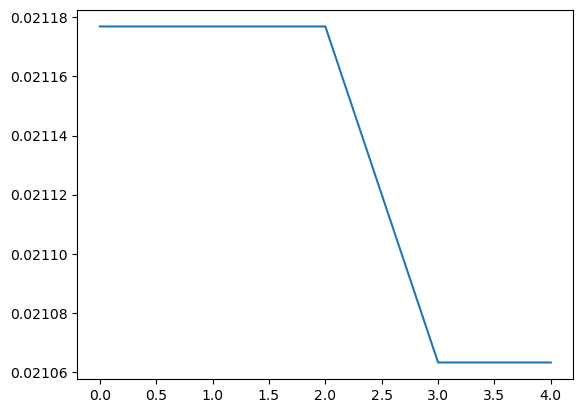

In [35]:
plt.plot(-np.array(best_values))